<a href="https://colab.research.google.com/github/vjbAvanzi/Group12_AppStat2021/blob/main/BallOnIncline_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyze Ball on Incline data


In [1]:
!pip install iminuit

     |████████████████████████████████| 334 kB 18.4 MB/s 


In [2]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from iminuit import Minuit
#sys.path.append('../../External_Functions')
#from ExternalFunctions import Chi2Regression

import pandas as pd

from scipy.signal import find_peaks # Brilliant function for finding maxima in a data set
from scipy import stats

nan = float('nan')

In [3]:
# Import ExternalFunctions from the github repo.
# Save ExternalFunctions as a local file
# Import functions as usual
# This ensures that the code will run in any directory on any system that we could possibly use (e.g. google colab)

import requests

url = 'https://raw.githubusercontent.com/AppliedStatisticsNBI/AppStat2021/main/External_Functions/ExternalFunctions.py'
with open('{}.py'.format('ExternalFunctions'), 'w') as file:
    file.write(requests.get(url).text)

from ExternalFunctions import Chi2Regression

# The Data


In [4]:
def calculate_weighted_mean(data, uncertainties):
    return np.sum(data/uncertainties**2)/np.sum(1./uncertainties**2)

def calculate_uncertainty(uncertainties):
    return np.sqrt(1./np.sum(1./uncertainties**2))

def calculate_df_mean_uncertainty_stdev(df, verbose=False):
    mean = []
    uncertainty = []
    stdev = []

    for index in range(1,df.shape[1],2):
        mean.append(calculate_weighted_mean(df.iloc[:, index],df.iloc[:, index+1]))
        uncertainty.append(calculate_uncertainty(df.iloc[:, index+1]))
        stdev.append(np.std(df.iloc[:, index], ddof=1))
        if verbose:
            print(df.columns[index])
            print(df.iloc[:, index].values)
            print('Mean:',mean[int(index/2)])
            print('Uncertainty:',uncertainty[int(index/2)])
            print('Standard deviation:',stdev[int(index/2)])

    return np.array(mean), np.array(uncertainty), np.array(stdev)

## The distances on the rail

In [5]:
rail_distances_columns = ['ExperimenterName', 'start(cm)', 'start_error(cm)', 'gate1(cm)', 'gate1_error(cm)', 'gate2(cm)', 'gate2_error(cm)', 'gate3(cm)', 'gate3_error(cm)', 'gate4(cm)', 'gate4_error(cm)', 'gate5(cm)', 'gate5_error(cm)']
rail_distances = [  ['P', 98.4 , 0.1 , 98.3 , 0.1 , 75.4 , 0.1 , 53.3 , 0.1 , 30.9 , 0.1 , 14.2 , 0.1 ],
                    ['A', 98.50, 0.05, 93.35, 0.05, 75.45, 0.05, 53.30, 0.05, 30.95, 0.05, 14.15, 0.05],
                    ['S', 98.44, 0.05, 93.32, 0.05, 75.45, 0.05, 53.25, 0.05, 30.90, 0.05, 14.70, 0.05],
                    ['N', 98.40, 0.05, 93.3 , 0.1 , 75.4 , 0.1 , 53.3 , 0.1 , 30.9 , 0.1 , 14.1 , 0.1 ] ]
df_rail_distances = pd.DataFrame(data=rail_distances,columns=rail_distances_columns)
display(df_rail_distances)
# Convert untis to SI
df_rail_distances.loc[:, df_rail_distances.columns != 'ExperimenterName'] *= 0.01 # Convert cm to m

rail_distances_mean, rail_distances_uncertainty, rail_distances_stdev = calculate_df_mean_uncertainty_stdev(df_rail_distances, verbose=True)
print('Mean:',rail_distances_mean)
print('Uncertainty:',rail_distances_uncertainty)
print('Standard deviation:',rail_distances_stdev)

,ExperimenterName,start(cm),start_error(cm),gate1(cm),gate1_error(cm),gate2(cm),gate2_error(cm),gate3(cm),gate3_error(cm),gate4(cm),gate4_error(cm),gate5(cm),gate5_error(cm)
0,P,98.40,0.10,98.30,0.10,75.40,0.10,53.30,0.10,30.90,0.10,14.20,0.10
1,A,98.50,0.05,93.35,0.05,75.45,0.05,53.30,0.05,30.95,0.05,14.15,0.05
2,S,98.44,0.05,93.32,0.05,75.45,0.05,53.25,0.05,30.90,0.05,14.70,0.05
3,N,98.40,0.05,93.30,0.10,75.40,0.10,53.30,0.10,30.90,0.10,14.10,0.10


start(cm)
[0.984  0.985  0.9844 0.984 ]
Mean: 0.9844307692307692
Uncertainty: 0.00027735009811261454
Standard deviation: 0.00047258156262520876
gate1(cm)
[0.983  0.9335 0.9332 0.933 ]
Mean: 0.93828
Uncertainty: 0.00031622776601683794
Standard deviation: 0.024884181722532105
gate2(cm)
[0.754  0.7545 0.7545 0.754 ]
Mean: 0.7544000000000001
Uncertainty: 0.00031622776601683794
Standard deviation: 0.0002886751345947811
gate3(cm)
[0.533  0.533  0.5325 0.533 ]
Mean: 0.5328
Uncertainty: 0.00031622776601683794
Standard deviation: 0.000250000000000028
gate4(cm)
[0.309  0.3095 0.309  0.309 ]
Mean: 0.3092
Uncertainty: 0.00031622776601683794
Standard deviation: 0.0002500000000000003
gate5(cm)
[0.142  0.1415 0.147  0.141 ]
Mean: 0.1437
Uncertainty: 0.00031622776601683794
Standard deviation: 0.002780137886268711
Mean: [0.98443077 0.93828    0.7544     0.5328     0.3092     0.1437    ]
Uncertainty: [0.00027735 0.00031623 0.00031623 0.00031623 0.00031623 0.00031623]
Standard deviation: [0.00047258 0.02

## The angle measurements for height 1
All measurements with goniometer should have 90 degrees substracted
<br>Variable names explained: S = setup, G = gionometer, N = normal position, F = flipped position

In [6]:
gonio_angles_1_columns = ['ExperimenterName', 'SNGN', 'SNGN_error', 'SNGF', 'SNGF_error', 'SFGN', 'SFGN_error', 'SFGF', 'SFGF_error']
gonio_angles_1 = [  ['P', 105.5, 0.2, 105.9 , 0.2 , 104.9 , 0.1 , 105.5 , 0.1 ],
                    ['A', 105.5, 0.2, 105.10, 0.25, 104.90, 0.25, 105.00, 0.25],
                    ['S', 105.6, 0.1, 105.9 , 0.1 , 104.8 , 0.1 , 105.05, 0.05],
                    ['N', 105.4, 0.2, 105.8 , 0.2 , 104.7 , 0.2 , 105.1 , 0.1 ] ]
df_gonio_angles_1 = pd.DataFrame(data=gonio_angles_1,columns=gonio_angles_1_columns)
df_gonio_angles_1.loc[:, ['SNGN','SNGF','SFGN','SFGF']] -= 90 # Substract the 90 degrees
df_gonio_angles_1.loc[:, df_gonio_angles_1.columns != 'ExperimenterName'] *= 2*np.pi/360 # Convert to radians
display(df_gonio_angles_1)


gonio_angles_1_mean, gonio_angles_1_uncertainty, gonio_angles_1_stdev = calculate_df_mean_uncertainty_stdev(df_gonio_angles_1)
print('Mean:',gonio_angles_1_mean)
print('Uncertainty:',gonio_angles_1_uncertainty)
print('Standard deviation:',gonio_angles_1_stdev)

,ExperimenterName,SNGN,SNGN_error,SNGF,SNGF_error,SFGN,SFGN_error,SFGF,SFGF_error
0,P,0.270526,0.003491,0.277507,0.003491,0.260054,0.001745,0.270526,0.001745
1,A,0.270526,0.003491,0.263545,0.004363,0.260054,0.004363,0.261799,0.004363
2,S,0.272271,0.001745,0.277507,0.001745,0.258309,0.001745,0.262672,0.000873
3,N,0.268781,0.003491,0.275762,0.003491,0.256563,0.003491,0.263545,0.001745


Mean: [0.27127403 0.2758987  0.25896775 0.26406605]
Uncertainty: [0.00131934 0.00135464 0.00112427 0.00070321]
Standard deviation: [0.00142506 0.00674083 0.00167103 0.00399111]


In [7]:
nan = float('nan')
triangle_distances_1_columns = ['ExperimenterName', 'h_a(mm)', 'h_a_error(mm)', 'h_b(mm)', 'h_b_error(mm)', 'l(mm)', 'l_error(mm)']
triangle_distances_1 = [['P', 278.5, 0.5, 31 , 1  , 926  , 1  ],
                        ['A', 278.0, 0.1, nan, nan, 927.0, 0.5],
                        ['N', 278.5, 0.5, 31 , 1  , 926  , 1  ] ]
df_triangle_distances_1 = pd.DataFrame(data=triangle_distances_1,columns=triangle_distances_1_columns)
display(df_triangle_distances_1)
df_triangle_distances_1.loc[:, df_triangle_distances_1.columns != 'ExperimenterName'] *= 0.001 # Convert mm to m

triangle_distances_1_mean, triangle_distances_1_uncertainty, triangle_distances_1_stdev = calculate_df_mean_uncertainty_stdev(df_triangle_distances_1)
print('Mean:',triangle_distances_1_mean)
print('Uncertainty:',triangle_distances_1_uncertainty)
print('Standard deviation:',triangle_distances_1_stdev)

,ExperimenterName,h_a(mm),h_a_error(mm),h_b(mm),h_b_error(mm),l(mm),l_error(mm)
0,P,278.5,0.5,31.0,1.0,926.0,1.0
1,A,278.0,0.1,NaN,NaN,927.0,0.5
2,N,278.5,0.5,31.0,1.0,926.0,1.0


Mean: [0.27803704 0.031      0.92666667]
Uncertainty: [9.62250449e-05 7.07106781e-04 4.08248290e-04]
Standard deviation: [0.00028868 0.         0.00057735]


## The angle measurements for height 2

In [8]:
# Note the lack of errors on the measurements of the flipped setup
gonio_angles_2_columns = ['ExperimenterName', 'SNGN', 'SNGN_error', 'SNGF', 'SNGF_error', 'SFGN', 'SFGF']
gonio_angles_2 = [['P', 95.6, 0.1, 95.2, 0.1, 95, 96]]
df_gonio_angles_2 = pd.DataFrame(data=gonio_angles_2,columns=gonio_angles_2_columns)
df_gonio_angles_2.loc[:, ['SNGN','SNGF','SFGN','SFGF']] -= 90 # Substract the 90 degrees
df_gonio_angles_2.loc[:, df_gonio_angles_2.columns != 'ExperimenterName'] *= 2*np.pi/360 # Convert to radians
display(df_gonio_angles_2)

print('One measurement -> no uncertainty or standard deviation calculations possible.')

,ExperimenterName,SNGN,SNGN_error,SNGF,SNGF_error,SFGN,SFGF
0,P,0.097738,0.001745,0.090757,0.001745,0.087266,0.10472


One measurement -> no uncertainty or standard deviation calculations possible.


In [9]:
# Use l from height 1
triangle_distances_2_columns = ['ExperimenterName', 'h_a(mm)', 'h_a_error(mm)', 'h_b(mm)', 'h_b_error(mm)']
triangle_distances_2 = [['?', 11.20, 0.02, 3.14, 0.02]]
df_triangle_distances_2 = pd.DataFrame(data=triangle_distances_2,columns=triangle_distances_2_columns)
display(df_triangle_distances_2)
df_triangle_distances_2.loc[:, df_triangle_distances_2.columns != 'ExperimenterName'] *= 0.001 # Convert mm to m

print('One measurement -> no uncertainty or standard deviation calculations possible.')

,ExperimenterName,h_a(mm),h_a_error(mm),h_b(mm),h_b_error(mm)
0,?,11.2,0.02,3.14,0.02


One measurement -> no uncertainty or standard deviation calculations possible.


## Remaining measured parameters

In [10]:
nan = float('nan')
remaining_parameters_columns = ['ExperimenterName', 'D_ball(mm)', 'D_ball_error(mm)', 'D_rail(mm)', 'D_rail_error(mm)', 'width_rail(mm)', 'width_rail_error(mm)']
remaining_parameters = [['P', 1.27, 0.01, 0.62, 0.02, 0.72, 0.02],
                        ['A', nan , nan , 0.61, 0.02, 0.71, 0.02],
                        ['N', 1.27, 0.01, nan , nan , nan , nan ] ]
df_remaining_parameters = pd.DataFrame(data=remaining_parameters,columns=remaining_parameters_columns)
display(df_remaining_parameters)
df_remaining_parameters.loc[:, df_remaining_parameters.columns != 'ExperimenterName'] *= 0.001 # Convert mm to m

remaining_parameters_mean, remaining_parameters_uncertainty, remaining_parameters_stdev = calculate_df_mean_uncertainty_stdev(df_remaining_parameters)
print('Mean:',remaining_parameters_mean)
print('Uncertainty:',remaining_parameters_uncertainty)
print('Standard deviation:',remaining_parameters_stdev)

,ExperimenterName,D_ball(mm),D_ball_error(mm),D_rail(mm),D_rail_error(mm),width_rail(mm),width_rail_error(mm)
0,P,1.27,0.01,0.62,0.02,0.72,0.02
1,A,NaN,NaN,0.61,0.02,0.71,0.02
2,N,1.27,0.01,NaN,NaN,NaN,NaN


Mean: [0.00127  0.000615 0.000715]
Uncertainty: [7.07106781e-06 1.41421356e-05 1.41421356e-05]
Standard deviation: [0.00000000e+00 7.07106781e-06 7.07106781e-06]


# Calculate average angle and $\Delta \theta$
- First deal with the error of the goniometer: flipping the goniometer for one version of the setup should give the exact opposite error compared to the normal measurement
- -> take the average of the two to find the real angle
- Then use the averages to find the delta theta between the normal setup and flipped setup

In [11]:
print(gonio_angles_1_columns[1:-1:2])
print(gonio_angles_1_mean)
print(gonio_angles_1_uncertainty)

gonio_SN_mean_1 = (gonio_angles_1_mean[0]+gonio_angles_1_mean[1])/2
gonio_SF_mean_1 = (gonio_angles_1_mean[2]+gonio_angles_1_mean[3])/2
gonio_SN_uncertainty_1 = np.sqrt(gonio_angles_1_uncertainty[0]**2 + gonio_angles_1_uncertainty[1]**2)/np.sqrt(2)
gonio_SF_uncertainty_1 = np.sqrt(gonio_angles_1_uncertainty[0]**2 + gonio_angles_1_uncertainty[1]**2)/np.sqrt(2)

gonio_dtheta_1 = (gonio_SN_mean_1-gonio_SF_mean_1)/2
gonio_edtheta_1 = np.sqrt(gonio_SN_uncertainty_1**2+gonio_SF_uncertainty_1**2)/np.sqrt(2)


gonio_SN_mean_2 = (df_gonio_angles_2.loc[0,'SNGN']+df_gonio_angles_2.loc[0,'SNGF'])/2
gonio_SF_mean_2 = (df_gonio_angles_2.loc[0,'SFGN']+df_gonio_angles_2.loc[0,'SFGF'])/2
gonio_SN_uncertainty_2 = np.sqrt(df_gonio_angles_2.loc[0,'SNGN_error']**2 + df_gonio_angles_2.loc[0,'SNGF_error']**2)/np.sqrt(2)
gonio_SF_uncertainty_2 = gonio_SN_uncertainty_2 # No errors given in the table, assume the same errors as for the other measurements

gonio_dtheta_2 = (gonio_SN_mean_2-gonio_SF_mean_2)/2
gonio_edtheta_2 = np.sqrt(gonio_SN_uncertainty_2**2+gonio_SF_uncertainty_1**2)/np.sqrt(2)


#def calculate_delta_theta(theta1, theta2, uncertainty1, uncertainty2):
#    return abs(theta1-theta2)/2, np.sqrt(uncertainty1**2 + uncertainty2**2)/np.sqrt(2)

#dthetaN, edthetaN = calculate_delta_theta(gonio_angles_1_mean[0],gonio_angles_1_mean[1], gonio_angles_1_uncertainty[0],gonio_angles_1_uncertainty[1])
#dthetaF, edthetaF = calculate_delta_theta(gonio_angles_1_mean[2],gonio_angles_1_mean[3], gonio_angles_1_uncertainty[2],gonio_angles_1_uncertainty[3])
#print(f'Delta theta 1 Normal = {dthetaN} +- {edthetaN} radians')
#print(f'Delta theta 1 Flipped = {dthetaF} +- {edthetaF} radians')
# Combined errors
#dthetaC = (dthetaN+dthetaF)/2
#edthetaC = np.sqrt(edthetaN**2+edthetaF**2)/np.sqrt(2)
#print(f'Delta theta 1 Combined = {dthetaC} +- {edthetaC} radians')

['SNGN', 'SNGF', 'SFGN', 'SFGF']
[0.27127403 0.2758987  0.25896775 0.26406605]
[0.00131934 0.00135464 0.00112427 0.00070321]


# Extracting and processing timing data

In [12]:
def read_csv(filename):
    """Read CSV from Waveforms
    This function takes in a filename and returns numpy arrays with time and voltage."""
    dat = np.genfromtxt(filename, delimiter=',', skip_header=13+6, names=True) # For our specific csv files we need to skip more header lines
    time = dat['Time_s']
    voltage = dat['Channel_1_V']
    return time, voltage

# lin_interp() and half_max_x() adapted from https://stackoverflow.com/questions/49100778/fwhm-calculation-using-python
def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]

def isolate_peaks(time, voltage, maxima_indices, width=0.05):
    """This function isolates the data points around a maximum and returns
    the time and voltage arrays for each peak in a list.
    The width parameter determines how many data points left and right of
    a maximum are take to be part of a peak."""
    peaks_x = []
    peaks_y = []
    for mx in maxima_indices:
        peak_slice = np.where( (time>time[mx]-width) & (time<time[mx]+width) ) # Slice around the maximum +-'width' seconds
        peaks_x.append(time[peak_slice])
        peaks_y.append(voltage[peak_slice])
    
    return peaks_x, peaks_y

def find_midpoints(time, voltage, width=0.05, show_plot=True):
    """Find midpoints -- quick and dirty"""
    
    # Write a function yourself, which identifies the peaks in the voltage,
    # and returns values for passing times and (possibly) their uncertainties in it.
    #t_pass = [0.0, 0.1]
    #t_pass_sigma = [0.0001, 0.00001]
    
    maxima_indices, _ = find_peaks(voltage,height=1.0) # Find the indices of the maxima/peaks
    #print(maxima_indices)
    
    # Isolate the peaks
    peaks_x, peaks_y = isolate_peaks(time, voltage, maxima_indices, width=width)
    # Confirm visually that all peaks have been selected correctly and that their non-zero parts do not overlap
    
    # Find the x positions corresponding to the half maximum
    hmts = [] # Half maximum time positionS
    centers = [] # Time of center of peaks
    widths = [] # Widths of the half maximum (not to be confused with the previously used width for selecting a peak)
    for i in range(len(maxima_indices)):
        hmt = half_max_x(peaks_x[i],peaks_y[i])
        center = (hmt[0] + hmt[1])/2
        width = hmt[1] - hmt[0]
        # Save the extracted parameters
        hmts.append(hmt)
        centers.append(center)
        widths.append(width)
    
    if show_plot:
        our_color_list = ['red','cyan','green','magenta','indigo'] # List of selected colors for ease of plotting
        
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(time, voltage, label='Measurements')
        ax.plot(time[maxima_indices], voltage[maxima_indices], marker='x', color='red', linestyle='none', ms=15, label='Maxima')
        for i in range(len(maxima_indices)):
            ax.plot(peaks_x[i], peaks_y[i], label=f'Peak {i+1}', color=our_color_list[i])
            ax.plot([centers[i],centers[i]],[0,voltage[maxima_indices[i]]+0.5],color=our_color_list[i]) # Plot a vertical line through the center of the peak
            half = voltage[maxima_indices[i]]/2.0
            ax.plot(hmts[i],[half,half],color=our_color_list[i]) # Plot the width of the peak
        
        # Use the xlim to inspect individual peaks
        # Below I have set up parameters for each peak of the first experiment
        # Note the increasingly narrow ranges
        #ax.set_xlim(-0.1,0.1) 
        #ax.set_xlim(0.25,0.35)
        #ax.set_xlim(0.50,0.55)
        #ax.set_xlim(0.65,0.70)
        #ax.set_xlim(0.78,0.80)

        ax.set_title("Data from Ball-on-Incline experiment")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (V)")
        ax.legend(loc='best')
    
    # For now we can use the center as the passing time and the width of the peak as the uncertainty.
    # Perhaps we can come up with a better method later
    t_pass = np.array(centers)
    t_pass_sigma = np.array(widths)/2.0
    
    return t_pass, t_pass_sigma

Passing times in seconds: [0.01271457 0.29772201 0.51363411 0.68096097 0.78983244]
Uncertainty on passing times: [0.01229155 0.00541882 0.00378095 0.0031676  0.00281644]


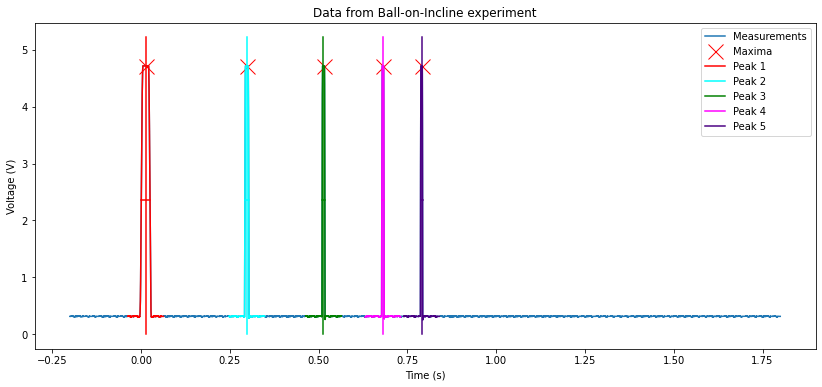

In [13]:
# Read the data and plot it (possibly with passing times in):
filename = 'https://raw.githubusercontent.com/vjbAvanzi/Group12_AppStat2021/main/Incline/Incline_Normal_height1_Run1.csv'

time, voltage = read_csv(filename)
timepass, timepass_sig = find_midpoints(time, voltage)

print('Passing times in seconds:',timepass)
print('Uncertainty on passing times:',timepass_sig)

A quick repeat of the cell above, but with a different data set for quick comparisons

Passing times in seconds: [0.01289845 0.2989662  0.51523661 0.68257141 0.79162088]
Uncertainty on passing times: [0.01247241 0.00543522 0.00380054 0.00317683 0.00282391]


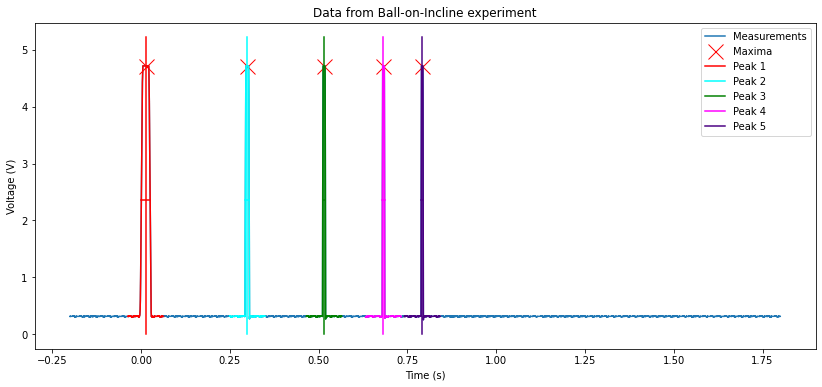

In [14]:
# Read the data and plot it (possibly with passing times in):
filename = 'https://raw.githubusercontent.com/vjbAvanzi/Group12_AppStat2021/main/Incline/Incline_Normal_height1_Run2.csv'

time, voltage = read_csv(filename)
timepass, timepass_sig = find_midpoints(time, voltage)

print('Passing times in seconds:',timepass)
print('Uncertainty on passing times:',timepass_sig)

In [15]:
def quadratic_equation(x, a, b, c):
    # Note that in our case x is the time and y (the returned value) is the position
    return 0.5*a*x**2 + b*x + c

def find_acceleration(timepass, timepass_sig, gate_positions, gate_positions_sig, verbose=True, veryverbose=True, show_plot=True):
    # From the drawing we made on paper to define the gates we see that gate 1 is
    # at the top of the slope and gate 5 is at the bottom. However, the distances
    # were measured from the bottom to the top of the slope. This is not a problem,
    # but it does mean that we should find a negative acceleration from the fit.
    chi2fit = Chi2Regression(quadratic_equation, timepass, gate_positions, gate_positions_sig)

    minuit_chi2 = Minuit(chi2fit, a=-1.0 ,b=0.0 ,c=0.0)
    minuit_chi2.errordef = 1.0         # This is the definition for ChiSquare fits
    if veryverbose:
        display(minuit_chi2.migrad())  # This is where the minimisation is carried out!
    else:
        minuit_chi2.migrad()           # This is where the minimisation is carried out!
    if (not minuit_chi2.fmin.is_valid):
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")
    
    if verbose:
        for name in minuit_chi2.parameters:
            print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_chi2.values[name], minuit_chi2.errors[name]))
    chi2 = minuit_chi2.fmin.fval
    Ndof = len(timepass) - len(minuit_chi2.values[:])
    Prob = stats.chi2.sf(chi2, Ndof)
    if verbose:
        print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

    a_fit, b_fit, c_fit = minuit_chi2.values[:]
    ea_fit, eb_fit, ec_fit = minuit_chi2.errors[:]
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(14, 6))
        
        ax.errorbar(timepass,gate_positions,yerr=gate_positions_sig,xerr=timepass_sig, label='Measurements', fmt='.')
        
        x_values = np.linspace(timepass[0],timepass[-1],1000)
        y_values = quadratic_equation(x_values, a_fit, b_fit, c_fit)
        ax.plot(x_values, y_values, linewidth=2.0, label=f'Fit with quadratic equation (Chi2 = {chi2:6.1f})')
        
        ax.set_title("Data from Ball-on-Incline experiment")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Position (m)")
        ax.legend(loc='best')
    
    return a_fit, ea_fit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 28.54                      │              Nfcn = 72               │
│ EDM = 5.28e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -1.537   │   0.005   │            │            │         │         │       │
│ 1 │ b    │  -0.4029  │  0.0019   │            │            │         │         │       │
│ 2 │ c    │ 943.64e-3 │  0.33e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         a         b         c │
├───┼───────────────────────────────┤
│ a │  2.04e-05 -8.19e-06  8.12e-07 │
│ b │ -8.19e-06  3.54e-06 -4.44e-07 │
│ c │  8.12e-07 -4.44e-07  1.07e-07 │
└───┴───────────────────────────────┘

Fit value (exp): a = -1.53724 +/- 0.00452
Fit value (exp): b = -0.40290 +/- 0.00188
Fit value (exp): c = 0.94364 +/- 0.00033
  Model fit:  Prob(Chi2=  28.5, Ndof=  2) = 0.00000


(-1.5372396901801908, 0.004520528447449959)

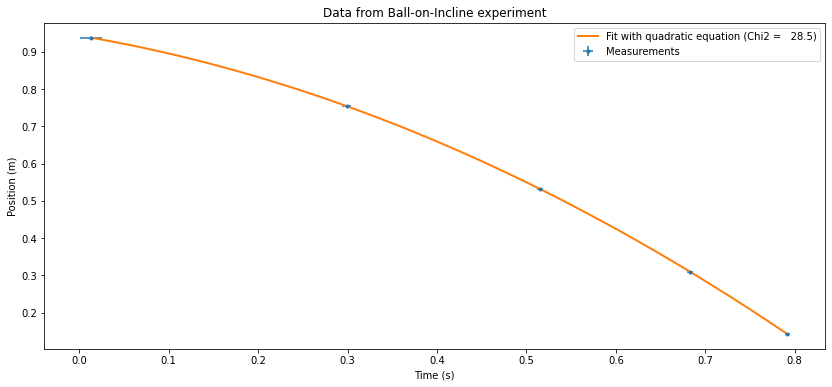

In [16]:
find_acceleration(timepass, timepass_sig, rail_distances_mean[1:], rail_distances_uncertainty[1:]) # Slicing to include only the gate positions and not the start position

# Repeat the code above for all timing measurements
Grouped by measurement series:
- N means normal, I means inverse/inverted, V means vertical
- 1 and 2 represent the height

Passing times in seconds: [0.01271457 0.29772201 0.51363411 0.68096097 0.78983244]
Uncertainty on passing times: [0.01229155 0.00541882 0.00378095 0.0031676  0.00281644]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 24.01                      │              Nfcn = 72               │
│ EDM = 9.33e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -1.537   │   0.005   │            │            │         │         │       │
│ 1 │ b    │  -0.4064  │  0.0019   │            │            │         │         │       │
│ 2 │ c    │ 943.61e-3 │  0.33e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         a         b         c │
├───┼───────────────────────────────┤
│ a │  2.06e-05 -8.24e-06  8.14e-07 │
│ b │ -8.24e-06  3.55e-06 -4.44e-07 │
│ c │  8.14e-07 -4.44e-07  1.07e-07 │
└───┴───────────────────────────────┘

Fit value (exp): a = -1.53742 +/- 0.00454
Fit value (exp): b = -0.40638 +/- 0.00188
Fit value (exp): c = 0.94361 +/- 0.00033
  Model fit:  Prob(Chi2=  24.0, Ndof=  2) = 0.00001
Passing times in seconds: [0.01289845 0.2989662  0.51523661 0.68257141 0.79162088]
Uncertainty on passing times: [0.01247241 0.00543522 0.00380054 0.00317683 0.00282391]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 28.54                      │              Nfcn = 72               │
│ EDM = 5.28e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -1.537   │   0.005   │            │            │         │         │       │
│ 1 │ b    │  -0.4029  │  0.0019   │            │            │         │         │       │
│ 2 │ c    │ 943.64e-3 │  0.33e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         a         b         c │
├───┼───────────────────────────────┤
│ a │  2.04e-05 -8.19e-06  8.12e-07 │
│ b │ -8.19e-06  3.54e-06 -4.44e-07 │
│ c │  8.12e-07 -4.44e-07  1.07e-07 │
└───┴───────────────────────────────┘

Fit value (exp): a = -1.53724 +/- 0.00452
Fit value (exp): b = -0.40290 +/- 0.00188
Fit value (exp): c = 0.94364 +/- 0.00033
  Model fit:  Prob(Chi2=  28.5, Ndof=  2) = 0.00000
Passing times in seconds: [0.01259878 0.29632496 0.51196815 0.67891532 0.78778423]
Uncertainty on passing times: [0.01219863 0.00540846 0.00378688 0.00315546 0.00281107]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 29.34                      │              Nfcn = 72               │
│ EDM = 1.43e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -1.539   │   0.005   │            │            │         │         │       │
│ 1 │ b    │  -0.4101  │  0.0019   │            │            │         │         │       │
│ 2 │ c    │ 943.60e-3 │  0.33e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         a         b         c │
├───┼───────────────────────────────┤
│ a │  2.08e-05  -8.3e-06  8.18e-07 │
│ b │  -8.3e-06  3.57e-06 -4.45e-07 │
│ c │  8.18e-07 -4.45e-07  1.07e-07 │
└───┴───────────────────────────────┘

Fit value (exp): a = -1.53882 +/- 0.00456
Fit value (exp): b = -0.41009 +/- 0.00189
Fit value (exp): c = 0.94360 +/- 0.00033
  Model fit:  Prob(Chi2=  29.3, Ndof=  2) = 0.00000
Mean a: -1.537822191307575
Uncertainty on mean of a: 0.0026216470415351555
Standard deviation of a: 0.0008659419912925402


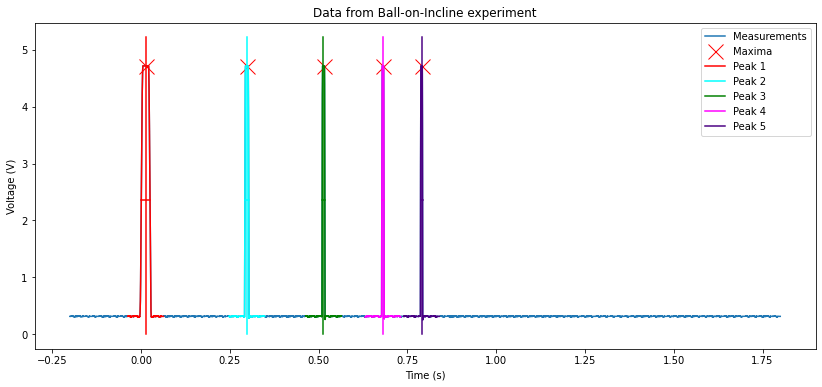

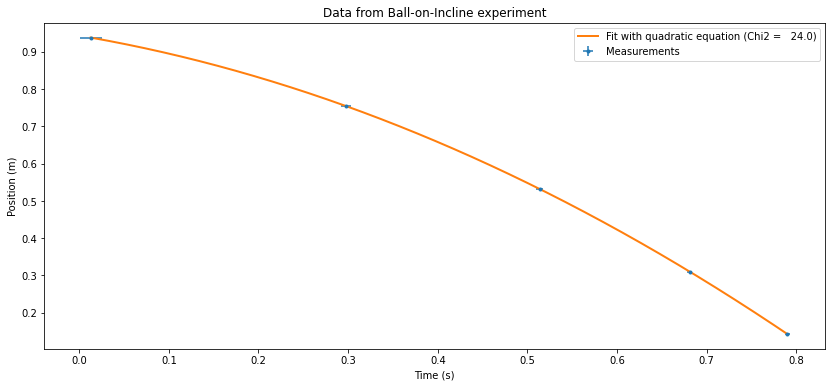

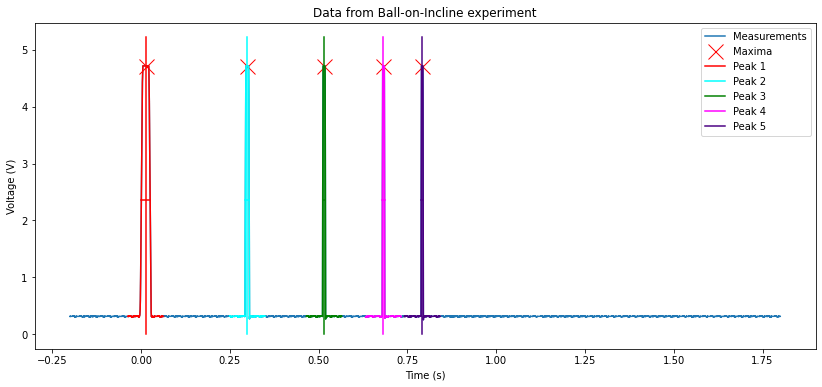

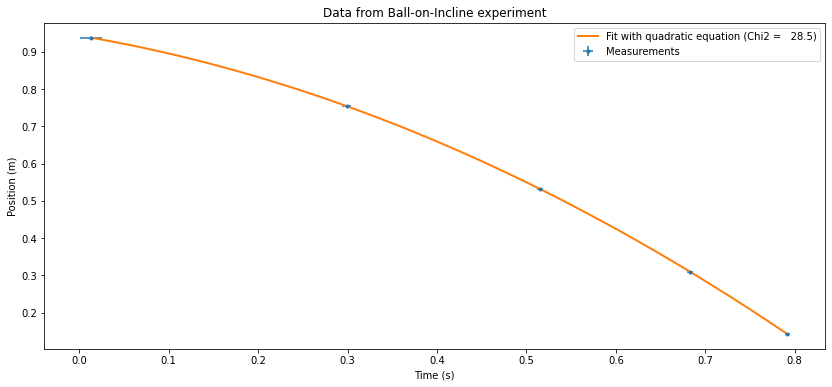

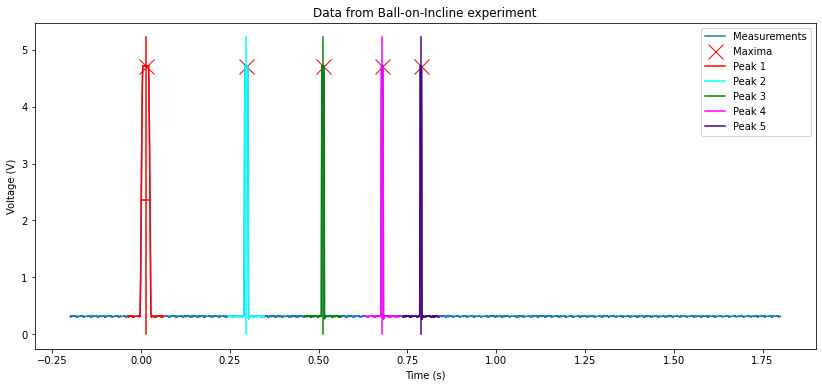

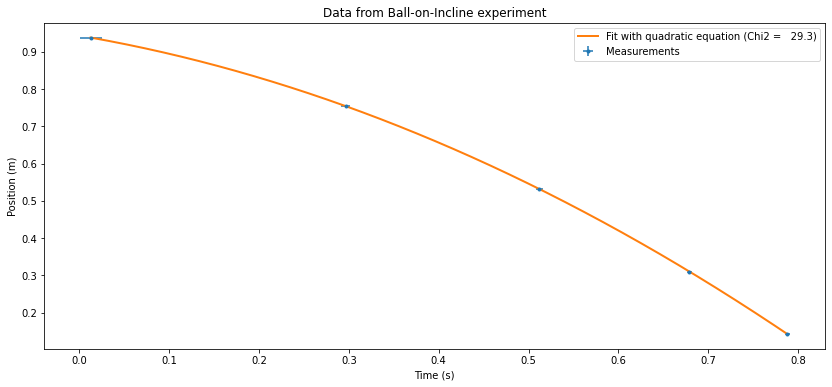

In [17]:
filenames_N1 = ['Incline_Normal_height1_Run1','Incline_Normal_height1_Run2','Incline_Normal_height1_Run3']
a_N1,ea_N1 = [],[]

for i,filename in enumerate(filenames_N1):
    filename = 'https://raw.githubusercontent.com/vjbAvanzi/Group12_AppStat2021/main/Incline/'+filename+'.csv'
    time, voltage = read_csv(filename)
    timepass, timepass_sig = find_midpoints(time, voltage)

    print('Passing times in seconds:',timepass)
    print('Uncertainty on passing times:',timepass_sig)
    
    a_fit, ea_fit = find_acceleration(timepass, timepass_sig, rail_distances_mean[1:], rail_distances_uncertainty[1:])
    a_N1.append(a_fit)
    ea_N1.append(ea_fit)

a_N1,ea_N1 = np.array(a_N1),np.array(ea_N1)

a_N1_mean = calculate_weighted_mean(a_N1,ea_N1)
a_N1_uncertainty = calculate_uncertainty(ea_N1)
a_N1_stdev = np.std(a_N1, ddof=1)

verbose = True
if verbose:
    print('Mean a:',a_N1_mean)
    print('Uncertainty on mean of a:',a_N1_uncertainty)
    print('Standard deviation of a:',a_N1_stdev)

In [18]:
def find_a(filenames, width=0.05, verbose=True, veryverbose=True, show_plot=True):
    a,ea = [],[]

    for i,filename in enumerate(filenames):
        filename = 'https://raw.githubusercontent.com/vjbAvanzi/Group12_AppStat2021/main/Incline/'+filename+'.csv'
        time, voltage = read_csv(filename)
        timepass, timepass_sig = find_midpoints(time, voltage, width=width, show_plot=show_plot)
        
        if verbose:
            print('Passing times in seconds:',timepass)
            print('Uncertainty on passing times:',timepass_sig)

        a_fit, ea_fit = find_acceleration(timepass, timepass_sig, rail_distances_mean[1:], rail_distances_uncertainty[1:]*3, verbose=verbose, veryverbose=veryverbose, show_plot=show_plot)
        a.append(a_fit)
        ea.append(ea_fit)

    a, ea = np.array(a), np.array(ea)

    a_mean = calculate_weighted_mean(a, ea)
    a_uncertainty = calculate_uncertainty(ea)
    a_stdev = np.std(a, ddof=1)

    print('Mean a:',a_mean)
    print('Uncertainty on mean of a:',a_uncertainty)
    print('Standard deviation of a:',a_stdev)
    
    return a, ea, a_mean, a_uncertainty, a_stdev

In [19]:
filenames_N1 = ['Incline_Normal_height1_Run1','Incline_Normal_height1_Run2','Incline_Normal_height1_Run3']
a_N1, ea_N1, a_mean_N1, a_uncertainty_N1, a_stdev_N1 = find_a(filenames_N1, veryverbose=False, show_plot=False)

Passing times in seconds: [0.01271457 0.29772201 0.51363411 0.68096097 0.78983244]
Uncertainty on passing times: [0.01229155 0.00541882 0.00378095 0.0031676  0.00281644]
Fit value (exp): a = -1.53742 +/- 0.01362
Fit value (exp): b = -0.40638 +/- 0.00565
Fit value (exp): c = 0.94361 +/- 0.00098
  Model fit:  Prob(Chi2=   2.7, Ndof=  2) = 0.26346
Passing times in seconds: [0.01289845 0.2989662  0.51523661 0.68257141 0.79162088]
Uncertainty on passing times: [0.01247241 0.00543522 0.00380054 0.00317683 0.00282391]
Fit value (exp): a = -1.53724 +/- 0.01356
Fit value (exp): b = -0.40290 +/- 0.00564
Fit value (exp): c = 0.94364 +/- 0.00098
  Model fit:  Prob(Chi2=   3.2, Ndof=  2) = 0.20485
Passing times in seconds: [0.01259878 0.29632496 0.51196815 0.67891532 0.78778423]
Uncertainty on passing times: [0.01219863 0.00540846 0.00378688 0.00315546 0.00281107]
Fit value (exp): a = -1.53882 +/- 0.01369
Fit value (exp): b = -0.41009 +/- 0.00567
Fit value (exp): c = 0.94360 +/- 0.00098
  Model fit

In [20]:
filenames_N2 = ['Incline_Normal_height2_ball2_Run1','Incline_Normal_height2_ball2_Run2','Incline_Normal_height2_ball2_Run3']
a_N2, ea_N2, a_mean_N2, a_uncertainty_N2, a_stdev_N2 = find_a(filenames_N2, verbose=False, veryverbose=False, show_plot=False)

Mean a: -0.51275739295333
Uncertainty on mean of a: 0.0026373167969823887
Standard deviation of a: 0.0029804126011952607


In [21]:
filenames_I1 = ['Incline_Inverted_height1_Run1','Incline_Inverted_height1_Run2','Incline_Inverted_height1_Run3']
a_I1, ea_I1, a_mean_I1, a_uncertainty_I1, a_stdev_I1 = find_a(filenames_I1, verbose=False, veryverbose=False, show_plot=False)

Mean a: -1.4860872112763404
Uncertainty on mean of a: 0.007574704954664206
Standard deviation of a: 0.0049828493375652285


In [22]:
filenames_I2 = ['Incline_Inverse_height2_ball2_Run1','Incline_Inverse_height2_ball2_Run2','Incline_Inverse_height2_ball2_Run3']
a_I2, ea_I2, a_mean_I2, a_uncertainty_I2, a_stdev_I2 = find_a(filenames_I2, verbose=False, veryverbose=False, show_plot=False)

Mean a: -0.465571693351983
Uncertainty on mean of a: 0.0023920120204606065
Standard deviation of a: 0.0055647401635483444


# Peaks are too close together for the vertical experiments, some code finetuning is required - done
# Last measurement is missing one peak, determine which gate didn't measure the ball passing (for now discard the 3rd run)

Passing times in seconds: [0.00798656 0.14509941 0.23664982 0.30610074 0.35095663]
Uncertainty on passing times: [0.00769834 0.00209636 0.00134728 0.00102627 0.0008635 ]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.888                      │              Nfcn = 62               │
│ EDM = 2.35e-14 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -9.49   │   0.07    │            │            │         │         │       │
│ 1 │ b    │  -0.615   │   0.013   │            │            │         │         │       │
│ 2 │ c    │  0.9436   │  0.0010   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         a         b         c │
├───┼───────────────────────────────┤
│ a │   0.00486 -0.000866  3.84e-05 │
│ b │ -0.000866  0.000166 -9.36e-06 │
│ c │  3.84e-05 -9.36e-06  1.01e-06 │
└───┴───────────────────────────────┘

Fit value (exp): a = -9.49462 +/- 0.06972
Fit value (exp): b = -0.61495 +/- 0.01290
Fit value (exp): c = 0.94355 +/- 0.00101
  Model fit:  Prob(Chi2=   2.9, Ndof=  2) = 0.23596
Passing times in seconds: [-0.12518035  0.00177263  0.0915624   0.16025743  0.20475402]
Uncertainty on passing times: [0.00540003 0.0016891  0.00122488 0.00121046 0.00108481]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.801                      │              Nfcn = 66               │
│ EDM = 8.5e-18 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -9.48   │   0.08    │            │            │         │         │       │
│ 1 │ b    │  -2.033   │   0.005   │            │            │         │         │       │
│ 2 │ c    │ 758.0e-3  │  0.7e-3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────┐
│   │         a         b         c │
├───┼───────────────────────────────┤
│ a │   0.00569 -0.000221 -3.74e-05 │
│ b │ -0.000221  2.15e-05   5.9e-07 │
│ c │ -3.74e-05   5.9e-07  4.84e-07 │
└───┴───────────────────────────────┘

Fit value (exp): a = -9.47644 +/- 0.07541
Fit value (exp): b = -2.03343 +/- 0.00464
Fit value (exp): c = 0.75803 +/- 0.00070
  Model fit:  Prob(Chi2=   2.8, Ndof=  2) = 0.24645
Mean a: -9.486244852015645
Uncertainty on mean of a: 0.05119307540709101
Standard deviation of a: 0.012854387632976565


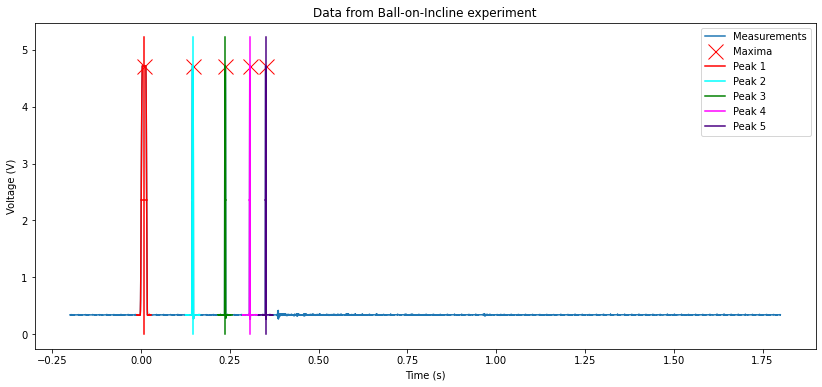

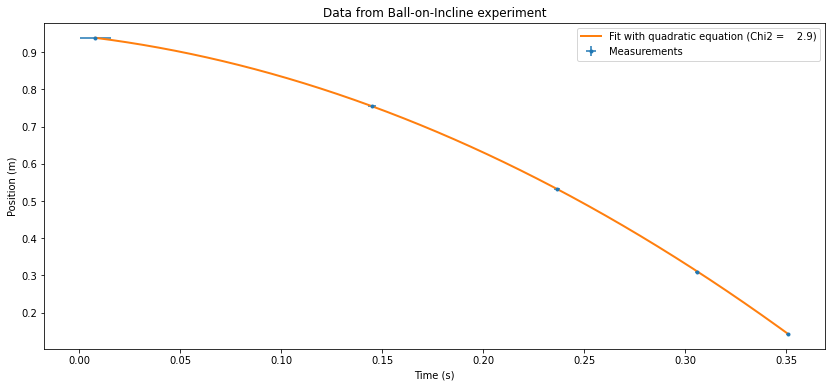

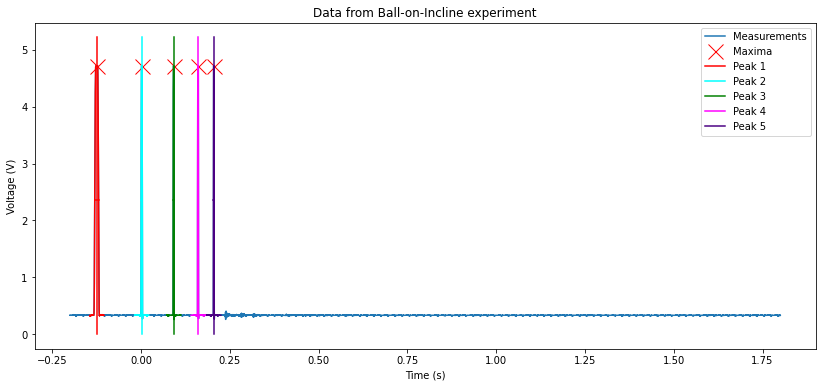

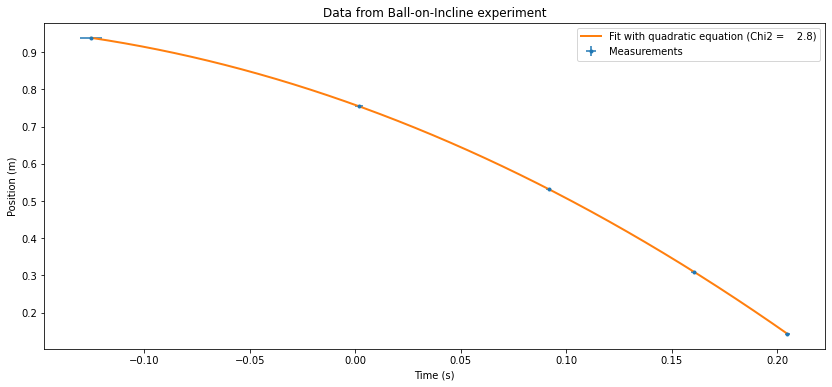

In [23]:
filenames_V = ['Incline_Vertical_Run1','Incline_Vertical_Run2']#,'Incline_Vertical_Run3']
a_V, ea_V, a_mean_V, a_uncertainty_V, a_stdev_V = find_a(filenames_V, width=0.02, veryverbose=True, show_plot=True)

In [24]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [25]:
from sympy import *

g, a, s, v, t, x0, theta, Dt, R, d = symbols("g, a, s, v, t, x_0, theta, Delta_theta, R, d")
dg, da, ds, dv, dt, dx0, dtheta, dDt, dR, dd = symbols("sigma_g, sigma_a, sigma_s, sigma_v, sigma_t, sigma_x_0, sigma_theta, sigma_Delta_theta, sigma_R, sigma_d")
g = (a /sin(theta + Dt))*(1 + (2/5)*(R**2)/(R**2 + (d/2)**2))
#s = 1/2 * a*t**2 + v*t + x0
#a = 2*(s - v*t - x0)/t**2
#da = sqrt((a.diff(t)*dt)**2 + (a.diff(s)*ds)**2)
dg = sqrt((g.diff(a)*da)**2 + (g.diff(theta)*dtheta)**2 + (g.diff(Dt)*dDt)**2 + (g.diff(R)*dR)**2 + (g.diff(d)*dd)**2)
lprint(latex(Eq(symbols('g'), g)))
lprint(latex(Eq(symbols('a'), a)))
lprint(latex(Eq(symbols('sigma_a'), da)))
lprint(latex(Eq(symbols('sigma_g'), dg)))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [26]:
a, x, v, t, x0 = symbols('a, x, v, t, x_0')
da, ds, dv, dt, dx0 = symbols('sigma_a, sigma_s, sigma_v, sigma_t, sigma_x_0')

#s = 1/2 * a*t**2 + v*t + x0
#a = 2*(s - v*t - x0)/t**2
#da = sqrt((a.diff(t)*dt)**2 + (a.diff(s)*ds)**2)

#lprint(latex(Eq(symbols('a'), a)))
#lprint(latex(Eq(symbols('sigma_a'), da)))
# We fit 'a' -> no need to use this calculation, ignore uncertainty on time?

# Theta from trigonometry (assuming right angle in triangle):
#print(triangle_distances_1_columns)
theta, ha, hb, l = symbols('theta, h_a, h_b, l')
dtheta, dha, dhb, dl = symbols('sigma_theta, sigma_h_a, sigma_h_b, sigma_l')

theta = atan((ha - hb) / l) # angle in radians!
dtheta = sqrt((theta.diff(ha)*dha)**2 + (theta.diff(hb)*dhb)**2 + (theta.diff(l)*dl)**2)

lprint(latex(Eq(symbols('theta'), theta)))
lprint(latex(Eq(symbols('sigma_theta'), dtheta)))

g, Dt, R, d = symbols("g, Delta_theta, R, d")
dg, dDt, dR, dd = symbols("sigma_g, sigma_Delta_theta, sigma_R, sigma_d")

# Unclear what R and d really are and whether they should be divided by 2 or not (so far I've seen all 4 possible combinations)
g = (a / sin(atan((ha - hb) / l) + Dt) ) * (1 + (2/5) * (R**2) / (R**2 - (d/2)**2))
dg = sqrt((g.diff(a)*da)**2 + (g.diff(ha)*dha)**2 + (g.diff(hb)*dhb)**2 + (g.diff(l)*dl)**2 + (g.diff(Dt)*dDt)**2 + (g.diff(R)*dR)**2 + (g.diff(d)*dd)**2)

lprint(latex(Eq(symbols('g'), g)))
lprint(latex(Eq(symbols('sigma_g'), dg)))

# Turn expression into numerical functions 
fg = lambdify((a,ha,hb,l,Dt,R,d), g)
fdg = lambdify((a,da,ha,dha,hb,dhb,l,dl,Dt,dDt,R,dR,d,dd), dg)

# Define values and their errors
va,vha,vhb,vl,vDt,vR,vd = -a_mean_N1, triangle_distances_1_mean[0],triangle_distances_1_mean[1],triangle_distances_1_mean[2], gonio_dtheta_1, remaining_parameters_mean[0],remaining_parameters_mean[1]
vda,vdha,vdhb,vdl,vdDt,vdR,vdd = a_uncertainty_N1, triangle_distances_1_uncertainty[0],triangle_distances_1_uncertainty[1],triangle_distances_1_uncertainty[2], gonio_edtheta_1, remaining_parameters_uncertainty[0],remaining_parameters_uncertainty[1]

# Numerically evaluate expressions and print
vg = fg(va,vha,vhb,vl,vDt,vR,vd)
vdg = fdg(va,vda,vha,vdha,vhb,vdhb,vl,vdl,vDt,vdDt,vR,vdR,vd,vdd)
lprint(fr'g = ({vg:.3f} \pm {vdg:.3f})\,\mathrm{{m/s^2}}')

print(remaining_parameters_mean)
print('The parameters going into the equation:')
lprint(fr'a = ({va:.5f} \pm {vda:.5f})\,\mathrm{{m/s^2}}')
lprint(fr'h_a = ({vha:.5f} \pm {vdha:.5f})\,\mathrm{{m}}')
lprint(fr'h_b = ({vhb:.5f} \pm {vdhb:.5f})\,\mathrm{{m}}')
lprint(fr'l = ({vl:.5f} \pm {vdl:.5f})\,\mathrm{{m}}')
lprint(fr'Delta_theta = ({vDt:.5} \pm {vdDt:.5f})\,rad')
lprint(fr'R = ({vR:.5f} \pm {vdR:.5f})\,\mathrm{{m}}')
lprint(fr'd = ({vd:.5f} \pm {vdd:.5f})\,\mathrm{{m}}')

print('Some intermediate results:')
ftheta = lambdify((ha,hb,l), theta)
fdtheta = lambdify((ha,dha,hb,dhb,l,dl), dtheta)
vtheta = ftheta(vha,vhb,vl)
vdtheta = fdtheta(vha,vdha,vhb,vdhb,vl,vdl)
lprint(fr'theta_trig = ({vtheta:.5f} \pm {vdtheta:.5f})\,rad')


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

[0.00127  0.000615 0.000715]
The parameters going into the equation:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Some intermediate results:


<IPython.core.display.Latex object>

In [27]:
# Theta from goniometer
# We measured theta + Delta theta -> simplifies the equation for g

g, a, theta, R, d = symbols("g, a, theta, R, d")
dg, da, dtheta, dR, dd = symbols("sigma_g, sigma_a, sigma_theta, sigma_R, sigma_d")

g = (a / sin(theta) ) * (1 + (2/5) * ((R)**2) / ((R)**2 - (d)**2))
dg = sqrt((g.diff(a)*da)**2 + (g.diff(theta)*dtheta)**2 + (g.diff(R)*dR)**2 + (g.diff(d)*dd)**2)

lprint(latex(Eq(symbols('g'), g)))
lprint(latex(Eq(symbols('sigma_g'), dg)))

# Turn expression into numerical functions 
fg = lambdify((a,theta,R,d), g)
fdg = lambdify((a,da,theta,dtheta,R,dR,d,dd), dg)

# Define values and their errors
va,vtheta,vR,vd = -a_mean_N1, gonio_angles_1_mean[0], remaining_parameters_mean[0],remaining_parameters_mean[1]
vda,vdtheta,vdR,vdd = a_uncertainty_N1, gonio_angles_1_uncertainty[0], remaining_parameters_uncertainty[0],remaining_parameters_uncertainty[1]

# Numerically evaluate expressions and print
vg = fg(va,vtheta,vR,vd)
vdg = fdg(va,vda,vtheta,vdtheta,vR,vdR,vd,vdd)
lprint(fr'g = ({vg:.3f} \pm {vdg:.3f})\,\mathrm{{m/s^2}}')

print('The parameters going into the equation:')
lprint(fr'a = ({va:.5f} \pm {vda:.5f})\,\mathrm{{m/s^2}}')
lprint(fr'theta = ({vtheta:.5} \pm {vdtheta:.5f})\,rad')
lprint(fr'R = ({vR:.5f} \pm {vdR:.5f})\,\mathrm{{m}}')
lprint(fr'd = ({vd:.5f} \pm {vdd:.5f})\,\mathrm{{m}}')


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The parameters going into the equation:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [28]:
g, a, theta, R, d = symbols("g, a, theta, R, d")
dg, da, dtheta, dR, dd = symbols("sigma_g, sigma_a, sigma_theta, sigma_R, sigma_d")

g = (a / sin(theta) ) * (1 + (2/5) * ((R)**2) / ((R)**2 - (d)**2))
#dg = sqrt((g.diff(a)*da)**2 + (g.diff(theta)*dtheta)**2 + (g.diff(R)*dR)**2 + (g.diff(d)*dd)**2)

#lprint(latex(Eq(symbols('g'), g)))
#lprint(latex(Eq(symbols('sigma_g'), dg)))

# Turn expression into numerical functions 
#fg = lambdify((a,theta,R,d), g)
#fdg = lambdify((a,da,theta,dtheta,R,dR,d,dd), dg)

# Find the impact on error for each parameter
ia = (g.diff(a)*da)**2
itheta = (g.diff(theta)*dtheta)**2
iR = (g.diff(R)*dR)**2
id = (g.diff(d)*dd)**2

# Turn into functions
fia = lambdify((a,da,theta,R,d), ia)
fitheta = lambdify((a,theta,dtheta,R,d), itheta)
fiR = lambdify((a,theta,R,dR,d), iR)
fid = lambdify((a,theta,R,d,dd), id)

# Define values and their errors
va,vtheta,vR,vd = -a_mean_N1, gonio_angles_1_mean[0], remaining_parameters_mean[0],remaining_parameters_mean[1]
vda,vdtheta,vdR,vdd = a_uncertainty_N1, gonio_angles_1_uncertainty[0], remaining_parameters_uncertainty[0],remaining_parameters_uncertainty[1]

# Numerically evaluate expressions and print
#vg = fg(va,vtheta,vR,vd)
#vdg = fdg(va,vda,vtheta,vdtheta,vR,vdR,vd,vdd)
lprint(fr'g = ({vg:.3f} \pm {vdg:.3f})\,\mathrm{{m/s^2}}')

vtheta_degr, vdtheta_degr = vtheta*180/np.pi, vdtheta*180/np.pi
print('The parameters going into the equation:')
lprint(fr'a = ({va:.5f} \pm {vda:.5f})\,\mathrm{{m/s^2}}')
lprint(fr'theta = ({vtheta_degr:.5} \pm {vdtheta_degr:.5f})\,degree')
lprint(fr'R = ({vR:.5f} \pm {vdR:.5f})\,\mathrm{{m}}')
lprint(fr'd = ({vd:.5f} \pm {vdd:.5f})\,\mathrm{{m}}')

via = fia(va,vda,vtheta,vR,vd)
vitheta = fitheta(va,vtheta,vdtheta,vR,vd)
viR = fiR(va,vtheta,vR,vdR,vd)
vid = fid(va,vtheta,vR,vd,vdd)

print('The Impact of parameters:')
lprint(fr'a = {via:.5f} \,\mathrm{{m^2/s^4}}')
lprint(fr'theta = {vitheta:.5} \,\mathrm{{m^2/s^4}}')
lprint(fr'R = {viR:.5f} \,\mathrm{{m^2/s^4}}')
lprint(fr'd = {vid:.5f} \,\mathrm{{m^2/s^4}}')

<IPython.core.display.Latex object>

The parameters going into the equation:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The Impact of parameters:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Calculate g for every experiment (using goniometer angles)

In [29]:
# All the stuff where we set up the equations
g, a, theta, R, d = symbols("g, a, theta, R, d")
dg, da, dtheta, dR, dd = symbols("sigma_g, sigma_a, sigma_theta, sigma_R, sigma_d")

g = (a / sin(theta) ) * (1 + (2/5) * ((R)**2) / ((R)**2 - (d)**2))
dg = sqrt((g.diff(a)*da)**2 + (g.diff(theta)*dtheta)**2 + (g.diff(R)*dR)**2 + (g.diff(d)*dd)**2)

# Turn expression into numerical functions (these are functions, just like those you get when using 'def')
fg = lambdify((a,theta,R,d), g)
fdg = lambdify((a,da,theta,dtheta,R,dR,d,dd), dg)

# Define values and their errors
# Values that are the same for all experiments
vR,vd = remaining_parameters_mean[0],remaining_parameters_mean[1]
vdR,vdd = remaining_parameters_uncertainty[0],remaining_parameters_uncertainty[1]

#Values that vary for each experiment -> function
def calculate_g_using_gonio(va,vda, vtheta,vdtheta, verbose=True, veryverbose=False):
    global vR,vdR, vd,vdd # Bad practice! Let's go!

    # Numerically evaluate expressions and print
    vg = fg(va,vtheta,vR,vd)
    vdg = fdg(va,vda,vtheta,vdtheta,vR,vdR,vd,vdd)
    if verbose:
        lprint(fr'g = ({vg:.2f} \pm {vdg:.2f})\,\mathrm{{m/s^2}}')

    if veryverbose:
        print('The parameters going into the equation:')
        lprint(fr'a = ({va:.5f} \pm {vda:.5f})\,\mathrm{{m/s^2}}')
        vtheta, vdtheta = vtheta*180/np.pi, vdtheta*180/np.pi
        lprint(fr'theta = ({vtheta:.5} \pm {vdtheta:.5f})\,rad')
        lprint(fr'R = ({vR:.5f} \pm {vdR:.5f})\,\mathrm{{m}}')
        lprint(fr'd = ({vd:.5f} \pm {vdd:.5f})\,\mathrm{{m}}')
    
    return vg, vdg

In [30]:
acceleration_means = [-a_mean_N1, -a_mean_I1, -a_mean_N2, -a_mean_I2, -a_mean_V]
acceleration_uncertainties = [a_uncertainty_N1, a_uncertainty_I1, a_uncertainty_N2, a_uncertainty_I2, a_uncertainty_V]
gonio_angles = [gonio_SN_mean_1, gonio_SF_mean_1, gonio_SN_mean_2, gonio_SF_mean_2, np.pi/2]
gonio_angles_uncertainties = [gonio_SN_uncertainty_1, gonio_SF_uncertainty_1, gonio_SN_uncertainty_2, gonio_SF_uncertainty_2, 0]
exp_names = ['SN1', 'SF1', 'SN2', 'SF2', 'Vertical']

gs, egs = [],[] # The g-values and their uncertainties
for i in range(5):
    print('Experiment '+exp_names[i])
    temp_g, temp_eg = calculate_g_using_gonio(acceleration_means[i],acceleration_uncertainties[i], gonio_angles[i],gonio_angles_uncertainties[i], veryverbose=True)
    gs.append(temp_g)
    egs.append(temp_eg)
print('It\'s not necessary to take the moment of inertia into account for the vertical case, because the ball doesn\'t roll over the rail.')
lprint(fr'g = ({-a_mean_V:.2f} \pm {a_uncertainty_V:.2f})\,\mathrm{{m/s^2}}')

Experiment SN1


<IPython.core.display.Latex object>

The parameters going into the equation:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Experiment SF1


<IPython.core.display.Latex object>

The parameters going into the equation:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Experiment SN2


<IPython.core.display.Latex object>

The parameters going into the equation:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Experiment SF2


<IPython.core.display.Latex object>

The parameters going into the equation:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Experiment Vertical


<IPython.core.display.Latex object>

The parameters going into the equation:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

It's not necessary to take the moment of inertia into account for the vertical case, because the ball doesn't roll over the rail.


<IPython.core.display.Latex object>